## Grupo

1. **Nomes:** Sophie Dilhon e Débora Ghiotti

2. **Matrículas:** 2019107591 e 2018102579

3. **Email:** sophie.gama@edu.ufes.br e debora.ghiotti@edu.ufes.br

4. **Curso(s):** Ciência da Computação

5. **Link do seu Colab com suas soluções (para que o professor possa acessar e rodar o código):** https://colab.research.google.com/drive/1pDwLE1ruAts3QWl0pK8NtdATk17mkL-7?usp=sharing

# Utilitários


Rodar essas células no caso de rodar o notebook no colab

In [ ]:
# Monta o Google Drive a VM Colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Muda o diretório atual para aquele em que os dados se encontram
%cd drive/MyDrive/T1_Datasci/

%ls

/content/drive/MyDrive/T1_Datasci
data/  __pycache__/  utils.py


In [ ]:
!pip install yellowbrick

In [ ]:
!pip install unidecode

     |████████████████████████████████| 235 kB 6.8 MB/s 


In [ ]:
# importa dependencias
import json
import os
import random
import string
import unidecode

import numpy as np

import pandas as pd
import nltk
nltk.download('punkt')

from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering

import scipy.cluster
import scipy.cluster.hierarchy as hierarchy

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import load_wine
from yellowbrick.cluster import KElbowVisualizer

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# utilitário criado com funções auxiliares
from utils import is_language_eng, find_genre, verify_conditions_book

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
%cd data/
%ls

/content/drive/MyDrive/T1_Datasci/data
goodreads_books_children.json
goodreads_books_comics_graphic.json
goodreads_books_fantasy_paranormal.json
goodreads_books_history_biography.json
goodreads_books_mystery_thriller_crime.json
goodreads_books_poetry.json
goodreads_books_romance.json
goodreads_books_young_adult.json


# Leitura de Dados

São lidos 2 mil livros de cada um dos 8 arquivos, esses dados são então inseridos em um dataframe, resultando em 16 mil livros lidos.

In [ ]:
data = []

# Lê todos os arquivos contidos na pasta data
for filename in os.listdir(os.getcwd()):
  genre = find_genre(filename)

  print("reading file: ", filename, genre)

  f = open(filename)

  lines = f.read().splitlines()  
  lines = [json.loads(item) for item in lines if verify_conditions_book(json.loads(item))]

  size = 2000 # int(len(lines) * 0.02)
  print(len(lines), size)

  # gera os samples aleatorios
  samples = random.sample(lines, size)

  for line in samples:
    line['genre'] = genre
    data.append(line) 

  f.close()

dados = pd.DataFrame(data, columns=['book_id', 'language_code', 'description', 'genre'])

reading file:  goodreads_books_fantasy_paranormal.json paranormal
139346 2000
reading file:  goodreads_books_mystery_thriller_crime.json mystery
93275 2000
reading file:  goodreads_books_history_biography.json biography
94992 2000
reading file:  goodreads_books_romance.json romance
186140 2000
reading file:  goodreads_books_comics_graphic.json comics
30461 2000
reading file:  goodreads_books_poetry.json poetry
8220 2000
reading file:  goodreads_books_young_adult.json young_adult
42969 2000
reading file:  goodreads_books_children.json children
34581 2000


In [ ]:
del(data)
del(samples)
del(lines)

In [ ]:
dados

,book_id,language_code,description,genre
0,17267479,en-GB,"The second book in the Broken Empire series, L...",paranormal
1,29356386,eng,"Rediscover her classic, most popular fantasy s...",paranormal
2,27313168,en-GB,This collection contains 18 previously publish...,paranormal
3,740039,en-US,"A fantasist without equal, Patricia A. McKilli...",paranormal
4,16390149,eng,"Extra, extra, read all about it: Zombies Invad...",paranormal
...,...,...,...,...
15995,105657,en-GB,"Abandoned at birth in the perilous Deepwoods, ...",children
15996,6797698,en-US,A hilarious picture book debut has a scurvy cr...,children
15997,34115685,eng,Harper and her friends get to visit the myster...,children
15998,1005719,eng,"Rockwell's famous Saturday Evening Postcovers,...",children


In [ ]:
df = dados.copy()

# Pré-processamento dos dados

Foram retirados os livros contendo lingua diferente de: ``en``, ``eng``,``en-GB``, ``en-US`` ou ``en-CA``.

O processamento dos dados das descrições foi feito seguindo os seguintes passos:
1. Dividir o texto em *tokens*
2. Remover símbolos de pontuação de cada *token*
3. Converter o texto para letras minúsculas
4. Converter caracteres especiais (passo discutível e necessidade deve ser analisada)
5. Remover *tokens* que não são palavras
6. Remover *tokens* que são *stop words*
7. Stemming

Foram feitos testes com o uso do Lemmetizer e do Stemming, obteve-se melhor resultado usando apenas o Stemming.

In [ ]:
# Toketinazação: Dividindo cada descrição em uma lista de substrings. 
df_tokenizado = df.copy()
df_tokenizado['description'] = df_tokenizado['description'].apply(word_tokenize)

In [ ]:
df = df_tokenizado.copy()

In [ ]:
table = str.maketrans('', '', string.punctuation)

df['description'] = df['description'].apply(lambda x: [w.translate(table) for w in x])

In [ ]:
df['description'] = df['description'].apply(lambda x: [w.lower() for w in x])

In [ ]:
df['description'] = df['description'].apply(lambda x:[unidecode.unidecode(w) for w in x])

In [ ]:
df['description'] = df['description'].apply(lambda x:[w for w in x if w.isalpha()])

In [ ]:
df['description']

0        [the, second, book, in, the, broken, empire, s...
1        [rediscover, her, classic, most, popular, fant...
2        [this, collection, contains, previously, publi...
3        [a, fantasist, without, equal, patricia, a, mc...
4        [extra, extra, read, all, about, it, zombies, ...
                               ...                        
15995    [abandoned, at, birth, in, the, perilous, deep...
15996    [a, hilarious, picture, book, debut, has, a, s...
15997    [harper, and, her, friends, get, to, visit, th...
15998    [rockwell, s, famous, saturday, evening, postc...
15999    [stories, of, what, chickadees, might, do, sec...
Name: description, Length: 16000, dtype: object

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['description'] = df['description'].apply(lambda x: [w for w in x if not w in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df['description']

0        [second, book, broken, empire, series, lawrenc...
1        [rediscover, classic, popular, fantasy, series...
2        [collection, contains, previously, published, ...
3        [fantasist, without, equal, patricia, mckillip...
4        [extra, extra, read, zombies, invade, london, ...
                               ...                        
15995    [abandoned, birth, perilous, deepwoods, twig, ...
15996    [hilarious, picture, book, debut, scurvy, crew...
15997    [harper, friends, get, visit, mysterious, nigh...
15998    [rockwell, famous, saturday, evening, postcove...
15999    [stories, chickadees, might, secretly, night, ...
Name: description, Length: 16000, dtype: object

In [ ]:
porter = PorterStemmer()

df['description'] = df['description'].apply(lambda x: [porter.stem(w) for w in x])

In [ ]:
df['description']

0                                   [tale, brother, grimm]
1        [oliv, go, sleep, much, want, tell, mother, ha...
2        [leav, fall, favorit, tree, fletcher, worri, s...
3        [one, littl, girl, life, good, live, two, mom,...
4        [meet, littl, bear, friend, million, children,...
                               ...                        
15995    [love, beauti, danger, scari, sublim, boy, eme...
15996    [sixteenyearold, riley, william, abl, see, gho...
15997    [great, standalon, almost, four, year, kitti, ...
15998    [sequel, bestsel, point, thriller, babysitt, b...
15999    [twelv, year, old, hannah, normal, girl, far, ...
Name: description, Length: 16000, dtype: object

# Matriz de TF-IDF

In [ ]:
# cria uma coluna contendo todas as palavras da descrição em uma frase
df['description_string'] = df['description'].apply(lambda x: ' '.join(x))

In [ ]:
df['description_string'].values

array(['second book broken empir seri lawrenc take young antihero one step closer grand ambit reach great must step bodi mani brother lie trodden wake walk pawn player win game though cost may drown world blood land burn fire hundr battl lord petti king fight broken empir long road aveng slaughter mother brother shown princ honor jorg ancrath hidden hand behind endless war saw game vow sweep board first though must gather piec learn rule play discov break six nation armi twenti thousand strong march toward jorg gate led champion belov peopl everi decent man pray shine hero unit empir heal wound everi omen say everi good king know bend knee face overwhelm odd save peopl land king jorg good king face enemi mani time strength jorg know win fair fight play fair never part jorg game plan',
       'rediscov classic popular fantasi seri tale flat earth demon god grant wonder wreak havoc visit upperearth dwell god underearth realm nightmarish demon innerearth domain dead flat earth home mortal

Ao aplicar o TF-IDF usou-se o parâmetro `min_df` que retira valores que não apareçam um mínimo de vezes. Para não afetar consideravelmente a característica de esparsidade da matriz, o valor usado foi de aparecer em pelo menos 0.05% dos livros. O TF-IDF é um cálculo que mede a importância de cada palavra na frase e no conjunto de descrições, a matriz resultado deste cálculo será utilizada para testar os agrupamentos.

In [ ]:
tfidf = TfidfVectorizer(min_df=0.0005) 
df_tfidf = tfidf.fit_transform(df['description_string'].values)

In [ ]:
df_tfidf

<16000x9848 sparse matrix of type '<class 'numpy.float64'>'
	with 927344 stored elements in Compressed Sparse Row format>

In [ ]:
tfidf_tokens = tfidf.get_feature_names_out()
df_tfidf = pd.DataFrame(data = df_tfidf.todense(), columns = tfidf_tokens)
df_tfidf

,aaron,abandon,abbey,abbi,abbott,abc,abduct,abe,abel,abhor,abid,abigail,abil,abl,aboard,abomin,abort,abound,abraham,abram,abridg,abroad,abrupt,abruptli,absenc,absent,absolut,absorb,abstract,absurd,abund,abus,abyss,academ,academi,accent,accept,access,accessori,accid,...,yield,yoga,yolen,yorick,york,yorker,yorkshir,young,youngadult,younger,youngest,youngster,youth,youtub,yu,yukon,yuletid,yummi,zach,zachari,zack,zander,zane,zani,zara,zeal,zealand,zealot,zebra,zelda,zen,zero,zeu,zoe,zoey,zombi,zone,zoo,zoom,zu
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.091234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250447,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0.0,0.106004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
15996,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
15997,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
15998,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


# SVD


Como os dados possuem uma alta quantidade de features, é necessário reduzir a dimensão da matriz, uma vez que com muitos dados seria mais dificil de trabalhar, tanto em questão de armazenamento quanto na eficiência do algoritmo de encontrar os clusters. Devido a esparsidade da matriz resultado do tf-idf, decidiu-se usar o algoritmo do SVD (Singular Value Decomposition), uma vez que este lida melhor com matrizes esparsas.

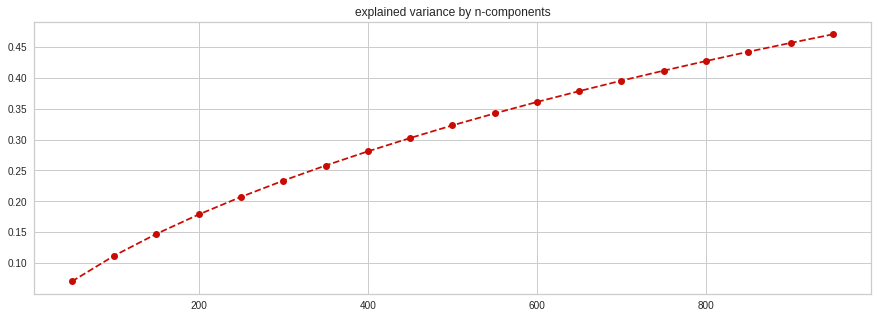

In [ ]:
performance = []
test = range(50, 1000, 50)

for n in test:
    svd = TruncatedSVD(n_components=n)
    lsa = svd.fit(df_tfidf)
    performance.append(lsa.explained_variance_ratio_.sum())

fig = plt.figure(figsize=(15, 5))
plt.plot(test, performance, 'ro--')
plt.title('explained variance by n-components');

In [ ]:
test[np.array(performance).argmax()]

950

In [ ]:
test[np.abs(np.gradient(np.gradient(performance))).argmax()]

150

Foram testados valores 18 valores entre 50 e 950 para o número de componentes do svd. A partir do gráfico pode-se conferir que as maiores dimensões obtiveram um melhor resultado. Porém, o elbow da curva, ou seja o ponto em que há uma diminuição da variância entre pontos, é em 150 componentes. Portanto escolheu-se diminuir a dimensão da matriz resultado do tf-idf para 150. Neste caso isso foi decidido pois escolher um valor muito baixo pode significar a perda de muitos features e portanto, apesar de mais fácil a classificação, o resultado não ser tão verídico. No entanto utilizar valores muito altos, apesar de representar bem os dados, pode adicionar complexidade que não ajude muito o algoritmo, além de tempo e recursos computacionais.

fonte: https://stackoverflow.com/questions/69091520/determine-the-correct-number-of-topics-using-latent-semantic-analysis

In [ ]:
svd_150 = TruncatedSVD(n_components=150)
svd_150_out = svd_150.fit_transform(df_tfidf)


print(svd_150.explained_variance_ratio_.sum())

0.14708689326992996


# Algoritmos de clusterização

## Kmeans

In [ ]:
# Criando o modelo para usar no elbow
kmeans = KMeans() 

Utilizando o Elbow method para auxílio da escolha do número de clusters no kmeans obteve-se como melhor valor para ***k*** 4, dessa forma será feito o agrupamento com o kmeans utilizando 4 clusters. Porém, notou-se que o resultado do elbow foi muito instável, variando muito a cada execução, assim foram feitos testes com também outros valores para k como será mostrado mais adiante.

fonte: https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

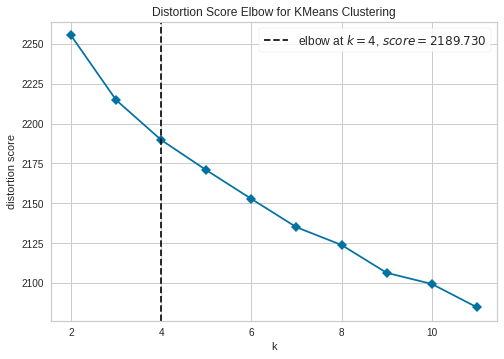

In [ ]:
visualizer = KElbowVisualizer(kmeans, k=(2, 12), timings=False)

visualizer.fit(svd_150_out)
visualizer.show()        

### Para k = 4

In [ ]:
# Fornecendo os parâmetros do modelo
kmeans = KMeans(n_clusters = 4) 

# ajustando o modelo
kmeans.fit(svd_150_out)

# obtendo o identificador de grupo de cada ponto
y_kmeans = kmeans.predict(svd_150_out)

# cada ponto é mapeado para um número, correspondente ao cluster
# ao qual foi associado
y_kmeans

array([1, 0, 0, ..., 1, 2, 2], dtype=int32)

In [ ]:
# quantidade de livro em cada cluster
np.unique(y_kmeans, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([3209, 4334, 7311, 1146]))

In [ ]:
df['clusters'] = y_kmeans
df.head()

,book_id,language_code,description,genre,description_string,clusters
0,7137664,eng,"[outwit, twit, mr, mr, twit, smelliest, uglies...",children,outwit twit mr mr twit smelliest ugliest peopl...,1
1,28191500,eng,"[magic, storytel, unforgett, charact, ben, doy...",children,magic storytel unforgett charact ben doyl rich...,0
2,25672147,eng,"[wheel, bu, take, new, bilingu, ident, childre...",children,wheel bu take new bilingu ident children sing ...,0
3,454852,en-US,"[use, school, librari, join, fudg, peter, shel...",children,use school librari join fudg peter shelia rest...,0
4,11539157,en-GB,"[greg, heffley, alway, hurri, grow, get, older...",children,greg heffley alway hurri grow get older realli...,1


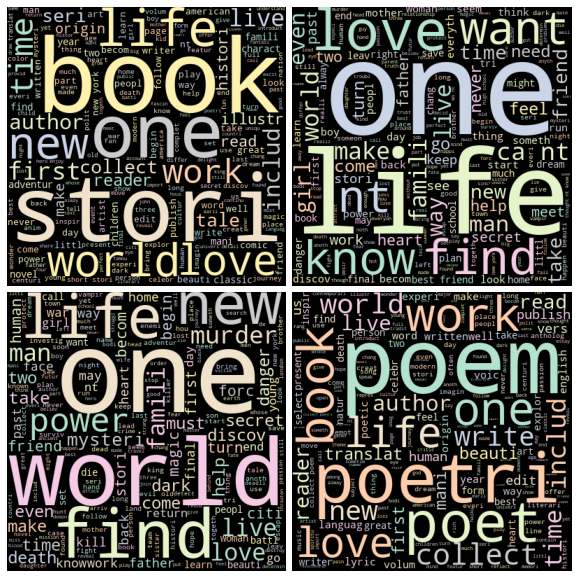

In [ ]:
#@title 

from wordcloud import WordCloud


fig = plt.figure(figsize = (8,8), facecolor = None, frameon=False) 


for i in range(4):
  text = [line['description_string'] for index, line in df.iterrows() if line['clusters'] == i]
  text = ''.join(text)
  
  wordcloud = WordCloud(width = 400, height = 400, 
                  background_color ='black', colormap='Pastel2' 
                  ).generate(text)
                  
  pos = i + 1
  label = 'Cluster {}'.format(pos)

  fig = plt.subplot(2, 2, pos)

  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0.5) 

plt.show()


Para analisar os clusters, foi feita uma nuvem de palavras para cada cluster e um gráfico de barras com a contagem de cada gênero presente no cluster. Por meio dessas visualizações é possível notar que o  quarto e segundo cluster aparentam um bom agrupamento dos gêneros poetry e romance/young_adult, respectivamente. 
Podemos notar isso tanto pelo gráfico de barras, quanto pelas palavras presentes nas nuvens (no quarto cluster: poem/poet/poetri e no segundo cluster: love/live/life).

Para os outros clusters a divisão tem alguns padrões, como a presença alta de livros do gênero children e comics no primeiro cluster e de mystery e paranormal no terceiro cluster. Mas ainda assim, existe grande presença de outros gêneros.

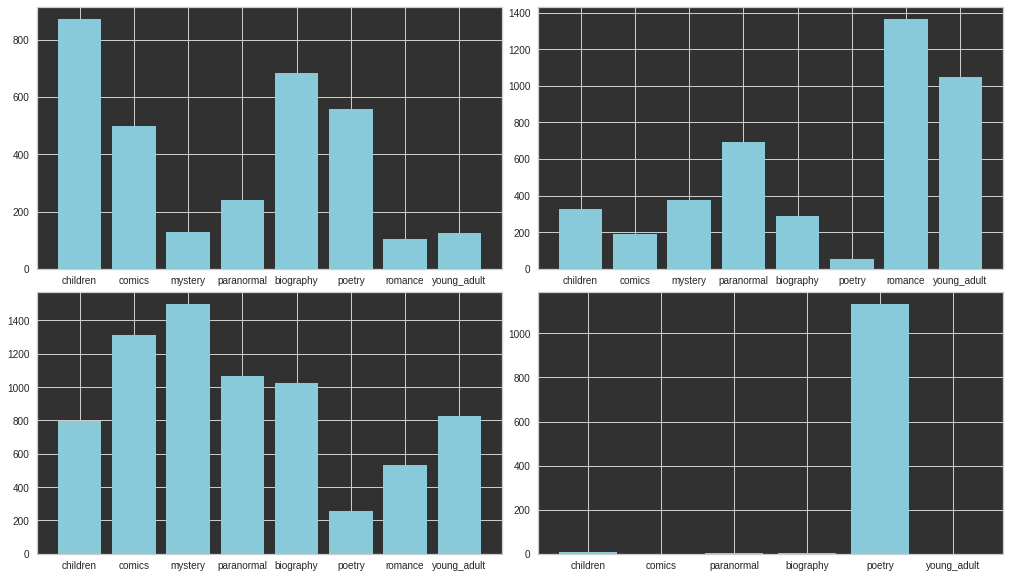

In [ ]:
#@title 
# fazer um histograma com para cada cluster com a quantidade por genero

fig = plt.figure(figsize = (14,8), facecolor = None, frameon=False) 

for i in range(4):
  grupo = df.loc[df['clusters'] == i]
  resultados = grupo['genre'].value_counts(sort=False)
  names = resultados.index
  resultados = resultados.values

  pos = i + 1

  fig = plt.subplot(2, 2, pos, facecolor='#313131')

  plt.bar(names, resultados, color='c')
  plt.tight_layout(pad = 0.5) 

plt.show()

### Para outros valores de k

A partir dos testes realizados notou-se que o melhor valor para k seria 4, uma vez que outros valores não apresentavam melhora na clusterização, abaixo demonstração para k sendo 5.

In [ ]:
# Fornecendo os parâmetros do modelo
kmeans = KMeans(n_clusters = 5) 

# ajustando o modelo
kmeans.fit(svd_150_out)

# obtendo o identificador de grupo de cada ponto
y_kmeans = kmeans.predict(svd_150_out)

# cada ponto é mapeado para um número, correspondente ao cluster
# ao qual foi associado
y_kmeans

array([1, 0, 3, ..., 1, 1, 0], dtype=int32)

In [ ]:
# quantidade de livro em cada cluster
np.unique(y_kmeans, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([6444, 3977,   74, 4300, 1205]))

In [ ]:
df['clusters_5_150'] = y_kmeans
df.head()

,book_id,language_code,description,genre,description_string,clusters_5_150
0,34598893,eng,"[littl, monster, bedtim, hard, especi, afraid,...",children,littl monster bedtim hard especi afraid scari ...,1
1,13589887,en-GB,"[sleepi, seasid, villag, porthaven, hide, myst...",children,sleepi seasid villag porthaven hide mysteri mi...,0
2,906216,en-US,"[novel, written, diari, form, tell, pivot, yea...",children,novel written diari form tell pivot year new e...,3
3,20326608,eng,"[belov, princess, movi, timedisney, cinderella...",children,belov princess movi timedisney cinderellai ret...,3
4,15796992,eng,"[dale, e, basy, send, milton, marlo, snivel, c...",children,dale e basy send milton marlo snivel circl res...,0


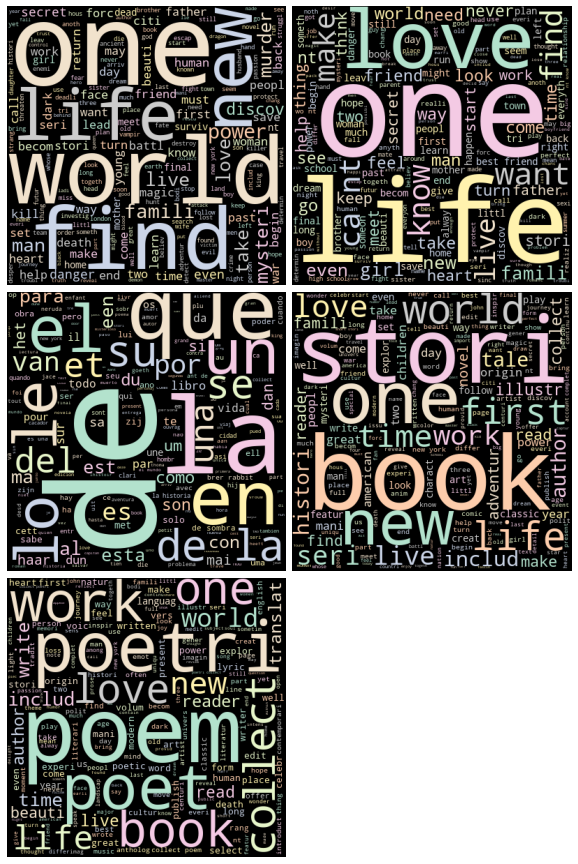

In [ ]:
#@title 

from wordcloud import WordCloud


fig = plt.figure(figsize = (8,12), facecolor = None, frameon=False) 


for i in range(5):
  # print('cluster', i)
  text = [line['description_string'] for index, line in df.iterrows() if line['clusters_5_150'] == i]
  text = ''.join(text)
  
  wordcloud = WordCloud(width = 400, height = 400, 
                  background_color ='black', colormap='Pastel2' 
                  ).generate(text)
                  
  pos = i + 1
  label = 'Cluster {}'.format(pos)

  fig = plt.subplot(3, 2, pos)

  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0.5) 

plt.show()


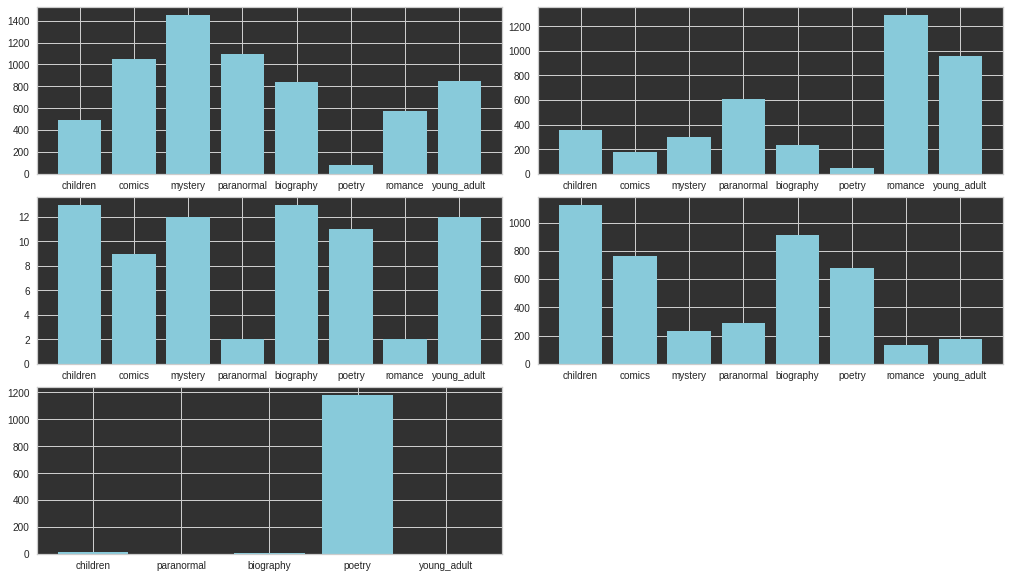

In [ ]:
#@title 
# fazer um histograma com para cada cluster com a quantidade por genero

fig = plt.figure(figsize = (14,8), facecolor = None, frameon=False) 

for i in range(5):
  grupo = df.loc[df['clusters_5_150'] == i]
  resultados = grupo['genre'].value_counts(sort=False)
  names = resultados.index
  resultados = resultados.values

  pos = i + 1

  fig = plt.subplot(3, 2, pos, facecolor='#313131')

  plt.bar(names, resultados, color='c')
  plt.tight_layout(pad = 0.5) 

plt.show()

### Ampliando a dimensão

Um questionamento que surge é se a diminuição da dimensão afetou os resultados dos clusters, e portanto se ao aumentar a dimensão features relevantes não seriam descartados e assim os clusters ficariam melhores agrupados.
Assim, são feitos testes com o uso do svd com mais componentes (não são usados menos pois comparado ao número de features da matriz seria uma diminuição muito grande, que consequentemente facilitaria a clusterização).

In [ ]:
svd_500 = TruncatedSVD(n_components=500)
svd_500_out = svd_500.fit_transform(df_tfidf)


print(svd_500.explained_variance_ratio_.sum())

0.3240816969181074


Os mesmos testes foram realizados com o número de clusters em relação ao caso com menos componentes.

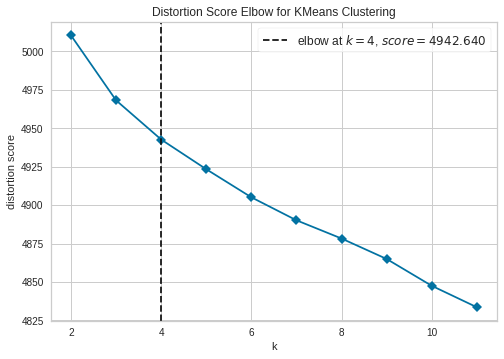

In [ ]:
visualizer = KElbowVisualizer(kmeans, k=(2, 12), timings=False) 

visualizer.fit(svd_500_out)
visualizer.show()

#### Para k = 4

In [ ]:
# Fornecendo os parâmetros do modelo
kmeans = KMeans(n_clusters = 4) 

# ajustando o modelo
kmeans.fit(svd_500_out)

# obtendo o identificador de grupo de cada ponto
y_kmeans = kmeans.predict(svd_500_out)
 
# cada ponto é mapeado para um número, correspondente ao cluster
# ao qual foi associado
y_kmeans

array([0, 1, 3, ..., 0, 0, 1], dtype=int32)

In [ ]:
df['clusters_4_500'] = y_kmeans
df.head()

,book_id,language_code,description,genre,description_string,clusters_5_150,clusters_4_500
0,34598893,eng,"[littl, monster, bedtim, hard, especi, afraid,...",children,littl monster bedtim hard especi afraid scari ...,1,0
1,13589887,en-GB,"[sleepi, seasid, villag, porthaven, hide, myst...",children,sleepi seasid villag porthaven hide mysteri mi...,0,1
2,906216,en-US,"[novel, written, diari, form, tell, pivot, yea...",children,novel written diari form tell pivot year new e...,3,3
3,20326608,eng,"[belov, princess, movi, timedisney, cinderella...",children,belov princess movi timedisney cinderellai ret...,3,3
4,15796992,eng,"[dale, e, basy, send, milton, marlo, snivel, c...",children,dale e basy send milton marlo snivel circl res...,0,1


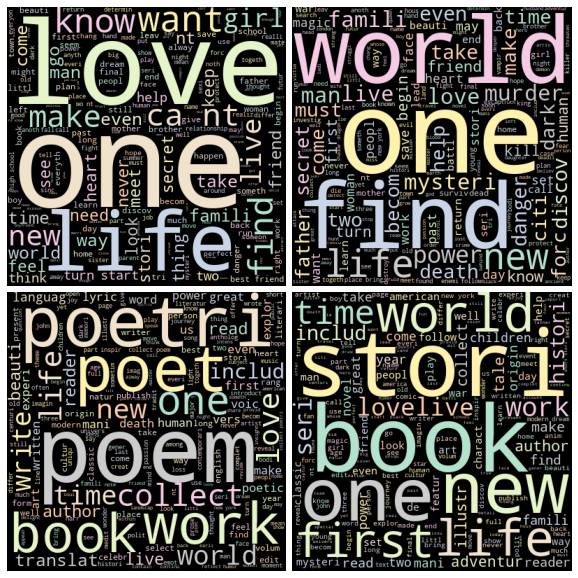

In [ ]:
#@title 

from wordcloud import WordCloud


fig = plt.figure(figsize = (8,8), facecolor = None, frameon=False) 


for i in range(4):
  text = [line['description_string'] for index, line in df.iterrows() if line['clusters_4_500'] == i]
  text = ''.join(text)
  
  wordcloud = WordCloud(width = 400, height = 400, 
                  background_color ='black', colormap='Pastel2' 
                  ).generate(text)
                  
  pos = i + 1
  label = 'Cluster {}'.format(pos)

  fig = plt.subplot(2, 2, pos)

  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0.5) 

plt.show()


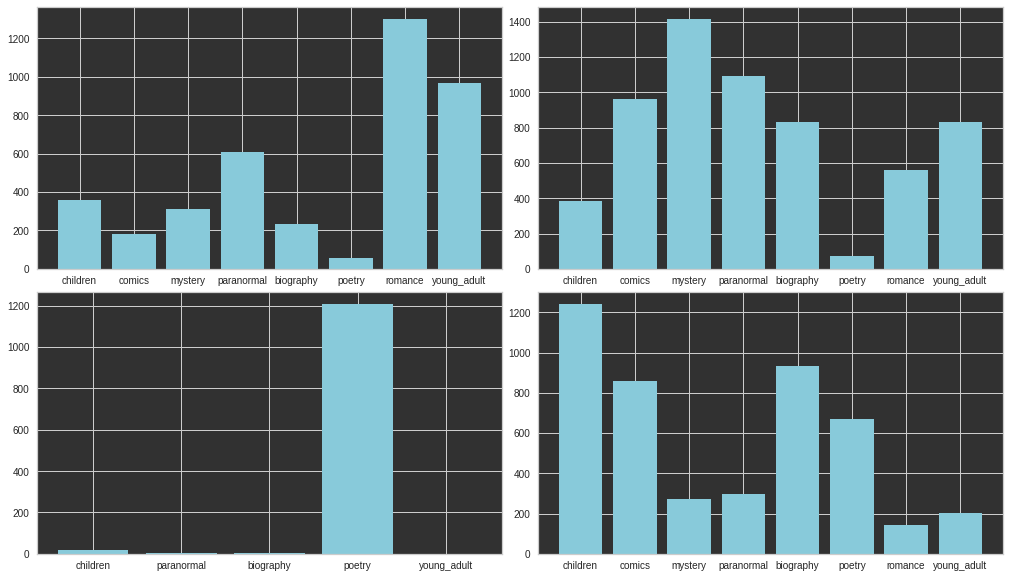

In [ ]:
#@title 
# fazer um histograma com para cada cluster com a quantidade por genero

fig = plt.figure(figsize = (14,8), facecolor = None, frameon=False) 

for i in range(4):
  grupo = df.loc[df['clusters_4_500'] == i]
  resultados = grupo['genre'].value_counts(sort=False)
  names = resultados.index
  resultados = resultados.values

  pos = i + 1

  fig = plt.subplot(2, 2, pos, facecolor='#313131')

  plt.bar(names, resultados, color='c')
  plt.tight_layout(pad = 0.5) 

plt.show()

Para k sendo 4 não notou-se uma grande diferença com a mudança do número de componentes, sendo os clusters e as quantidades muito similares.

#### Para outros valores de k

In [ ]:
# Fornecendo os parâmetros do modelo
kmeans = KMeans(n_clusters = 5) 

# ajustando o modelo
kmeans.fit(svd_500_out)

# obtendo o identificador de grupo de cada ponto
y_kmeans = kmeans.predict(svd_500_out)

# cada ponto é mapeado para um número, correspondente ao cluster
# ao qual foi associado
y_kmeans

array([2, 0, 4, ..., 0, 2, 2], dtype=int32)

In [ ]:
df['clusters_5_500'] = y_kmeans
df.head()

,book_id,language_code,description,genre,description_string,clusters_5_150,clusters_4_500,clusters_5_500
0,34598893,eng,"[littl, monster, bedtim, hard, especi, afraid,...",children,littl monster bedtim hard especi afraid scari ...,1,0,2
1,13589887,en-GB,"[sleepi, seasid, villag, porthaven, hide, myst...",children,sleepi seasid villag porthaven hide mysteri mi...,0,1,0
2,906216,en-US,"[novel, written, diari, form, tell, pivot, yea...",children,novel written diari form tell pivot year new e...,3,3,4
3,20326608,eng,"[belov, princess, movi, timedisney, cinderella...",children,belov princess movi timedisney cinderellai ret...,3,3,4
4,15796992,eng,"[dale, e, basy, send, milton, marlo, snivel, c...",children,dale e basy send milton marlo snivel circl res...,0,1,2


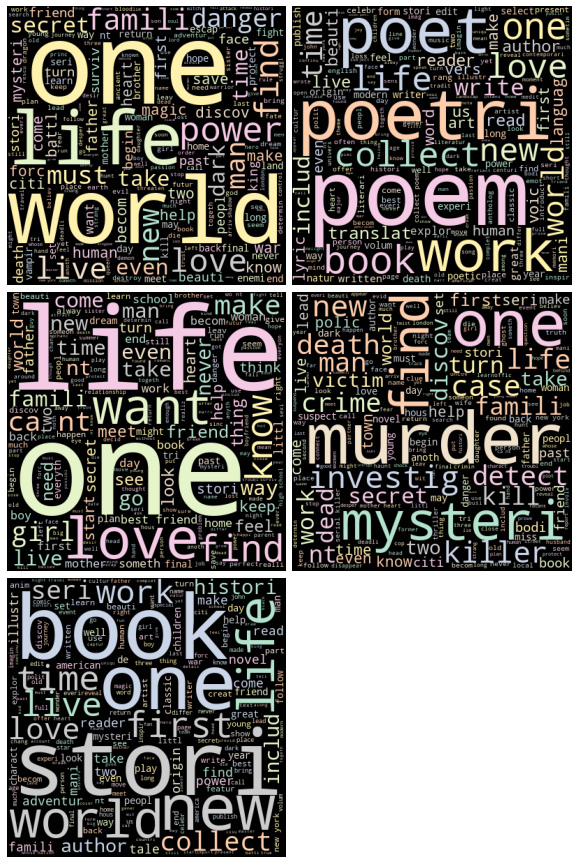

In [ ]:
#@title 

from wordcloud import WordCloud


fig = plt.figure(figsize = (8,12), facecolor = None, frameon=False) 


for i in range(5):
  # print('cluster', i)
  text = [line['description_string'] for index, line in df.iterrows() if line['clusters_5_500'] == i]
  text = ''.join(text)
  
  wordcloud = WordCloud(width = 400, height = 400, 
                  background_color ='black', colormap='Pastel2' 
                  ).generate(text)
                  
  pos = i + 1
  label = 'Cluster {}'.format(pos)

  fig = plt.subplot(3, 2, pos)

  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0.5) 

plt.show()


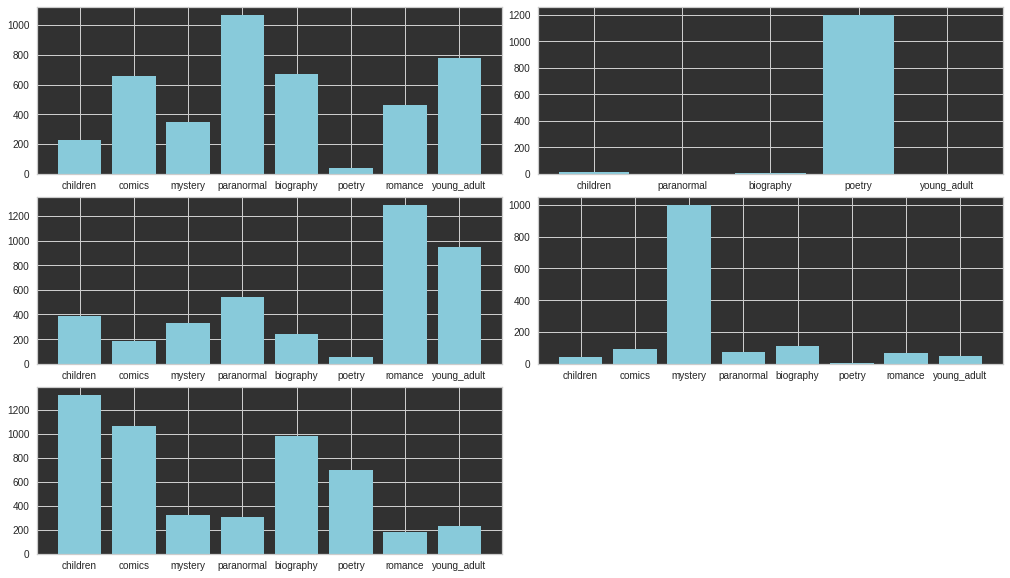

In [ ]:
#@title 
# fazer um histograma com para cada cluster com a quantidade por genero

fig = plt.figure(figsize = (14,8), facecolor = None, frameon=False) 

for i in range(5):
  grupo = df.loc[df['clusters_5_500'] == i]
  resultados = grupo['genre'].value_counts(sort=False)
  names = resultados.index
  resultados = resultados.values

  pos = i + 1

  fig = plt.subplot(3, 2, pos, facecolor='#313131')

  plt.bar(names, resultados, color='c')
  plt.tight_layout(pad = 0.5) 

plt.show()

Já ao testar o agrupamento em 5 clusters obteve-se um resultado diferente, além dos grupos de poesia e romance, outro grupo foi bem separado, este contendo cerca de 50% dos livros do gênero mystery. Portanto pode-se perceber que o número de dimensões pode sim alterar os resultados, uma vez que este pode incluir features que sejam consideráveis ao agrupamento. O mesmo teste foi feito com mais clusters, mas no entanto não notou-se melhora nos resultados.

# Hierarquico

O segundo modelo testado foi o agrupamento hierárquico. Para ele foi utilizado como cálculo de distância os seguintes algoritmos:
*   Complete-linkage
*   Single-linkage
*   Average-linkage
*   Ward

Para cada um dos casos, foi feita a analise do dendograma assim como a avaliação do resultado do modelo.

## Hierarquico Complete-Linkage

A distância entre dois grupos é a distância entre os dois pontos mais distantes que estão em grupos distintos.

### Dendograma

Pelo dendograma do agrupamento hierarquico utilizando o complete-linkage, o número de grupos (clusters) escolhido foi 4. 

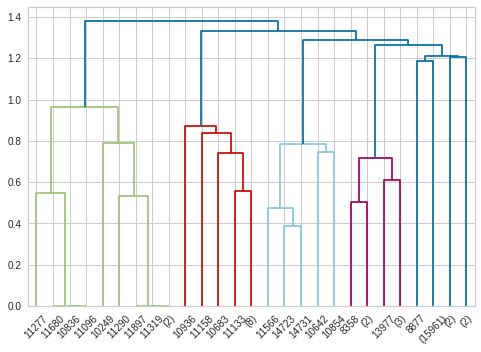

In [ ]:
agrup_hie_complete = hierarchy.linkage(svd_150_out, method='complete')
hierarchy.dendrogram(agrup_hie_complete,p=5,truncate_mode="level");

Ao realizar o teste com o número de grupos igual a 4, é possível ver que a distribuição de elementos entre os grupos ficou muito desbalanceda, logo esse agrupamento teve uma performance ruim. Por causa disso, não foi necessário fazer outras analises do resultado. Assim, decidimos realizar o teste com 5 grupos. 

In [ ]:
print("HIERARQUICO COMPLETE 4")
hie_complete_4 = AgglomerativeClustering(4, linkage = 'complete')
hie_complete_4.fit(svd_150_out);
print(np.unique(hie_complete_4.labels_, return_counts=True))


HIERARQUICO COMPLETE 4
(array([0, 1, 2, 3]), array([15973,    10,    12,     5]))


Testando com 5 grupos, não ocorreu nenhum melhora significativa de performance. Assim, concluimos que o agrupamento hierarquico utilizando o complete linkage não é uma boa solução.

In [ ]:
print("HIERARQUICO COMPLETE 5")
hie_complete_5 = AgglomerativeClustering(5, linkage = 'complete')
hie_complete_5.fit(svd_150_out);
print(np.unique(hie_complete_5.labels_, return_counts=True))

HIERARQUICO COMPLETE 5
(array([0, 1, 2, 3, 4]), array([15966,    10,    12,     5,     7]))


## Hierarquico Single-Linkage
A distância entre dois grupos é a distância entre os dois pontos mais próximos que estão em grupos distintos.

### Dendograma

Pelo dendograma do agrupamento hierarquico utilizando o single-linkage, já é possível ver que o algoritmo não é capaz de fazer uma boa divisão dos grupos. Visto que não é possível escolher um número de grupos de forma clara, foi escolhido o mesmo número do kmeans e do complete-linkage apenas para validar a analiser prévia do dendograma.

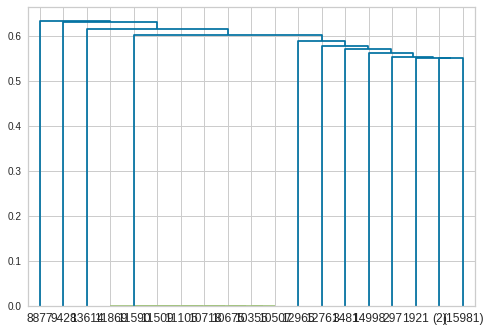

In [ ]:
agrup_hie_single = hierarchy.linkage(svd_150_out, method='single')
hierarchy.dendrogram(agrup_hie_single,p=10,truncate_mode="level");

Ao realizar o teste com o número de grupos igual a 4/5, é possível ver que a distribuição de elementos entre os grupos ficou completamente desbalanceda. Sendo assim concluimos que o single-linkage não era uma solução viavel para esse problema.

In [ ]:
print("HIERARQUICO SINGLE 4")
hie_single_4 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage = 'single')
hie_single_4.fit_predict(svd_150_out);
np.unique(hie_single_4.labels_, return_counts=True)

HIERARQUICO SINGLE 4


(array([0, 1, 2, 3]), array([15997,     1,     1,     1]))

## Hierarquico Average-Linkage
A distância entre dois grupos é a distância média entre todos os pares de pontos (cada ponto do par pertencente a grupos distintos).

### Dendograma

Pelo dendograma do agrupamento hierarquico utilizando o average-linkage, o número de grupos (clusters) escolhido foi 5. 

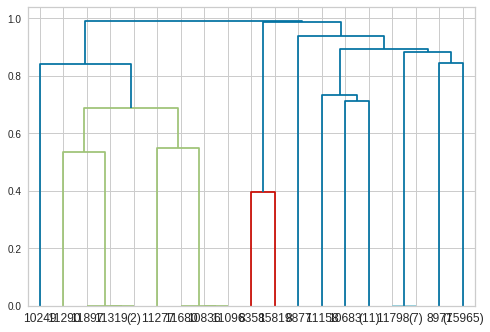

In [ ]:
agrup_hie_average = hierarchy.linkage(svd_150_out, method='average')
hierarchy.dendrogram(agrup_hie_average,p=5,truncate_mode="level");

Assim como os outros agrupamentos, o average-linkage obteve uma distribuição muito ruim de dados que já denuncia a péssima performance do modelo. Por isso, esse modelo tambem foi descartado como opção para o agrupamento da descrição dos livros

In [ ]:
print("HIERARQUICO AVERAGE 5")
hie_average_5 = AgglomerativeClustering(5, linkage = 'average')
hie_average_5.fit(svd_150_out);
np.unique(hie_average_5.labels_, return_counts=True)

HIERARQUICO AVERAGE 5


(array([0, 1, 2, 3, 4]), array([15974,    10,     2,     1,    13]))

## Hierarquico Ward-Linkage
No método ligação de Ward, a distância entre dois agrupamentos é a soma dos desvios quadrados dos pontos aos centroides. O objetivo da ligação de Ward é minimizar a soma dos quadrados dentro do agrupamento.

### Dendograma

Pelo dendograma do agrupamento hierarquico utilizando o ward-linkage, os números de grupos (clusters) escolhidos foram 4, 5 e 6. De todos os agrupamentos hierarquicos testados, a distância de ward foi a mais claro no número de clusters

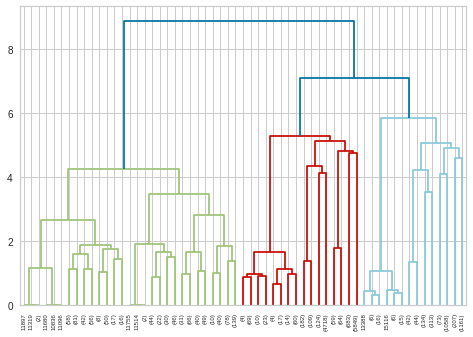

In [ ]:
agrup_hie_ward = hierarchy.linkage(svd_150_out, method='ward')
hierarchy.dendrogram(agrup_hie_ward,p=5,truncate_mode="level");

Com o número de clusters igual a 4, ocorreu uma melhora significativa na distribuição dos dados.

In [ ]:
print("HIERARQUICO WARD 4")
hie_ward_4 = AgglomerativeClustering(4, linkage = 'ward')
hie_ward_4.fit(svd_150_out);
np.unique(hie_ward_4.labels_, return_counts=True)

HIERARQUICO WARD 4


(array([0, 1, 2, 3]), array([11989,   934,  3032,    45]))

Aumentando o número para 5, não tivemos uma diferença muito grande no resultado

In [ ]:
print("HIERARQUICO WARD 5")
hie_ward_5 = AgglomerativeClustering(5, linkage = 'ward')
clusters_hie_ward_5 = hie_ward_5.fit(svd_150_out);
np.unique(hie_ward_5.labels_, return_counts=True)

HIERARQUICO WARD 5


(array([0, 1, 2, 3, 4]), array([11788,   934,  3032,    45,   201]))

Com 6 clusters o agrupamento melhorou muito em relação aos outros modelos. Já é possível ter uma distribuição interessante (mesmo que não muito boa). Por isso, o agrupamente hierarquico utilizando a distância de ward com 6 clusters foi escolhido para ser analisado mais afundo e comparado com o kmeans

In [ ]:
print("HIERARQUICO WARD 6")
hie_ward_6 = AgglomerativeClustering(6, linkage = 'ward')
clusters_hie_ward_6 = hie_ward_6.fit(svd_150_out);
np.unique(hie_ward_6.labels_, return_counts=True)

HIERARQUICO WARD 6


(array([0, 1, 2, 3, 4, 5]), array([3032,  934, 6655,   45,  201, 5133]))

Na imagem abaixo, temos a distribuição dos gêneros literários por cluster. O modelo conseguiu agrupar o gênero poetry e um pouco do gênero romance, por mais que ele se confunda com o young_adult. O restante dos clusters ficaram ou muito misturados ou com poucos dados.

In [ ]:
df['cluster_ward_6_150'] = clusters_hie_ward_6.labels_

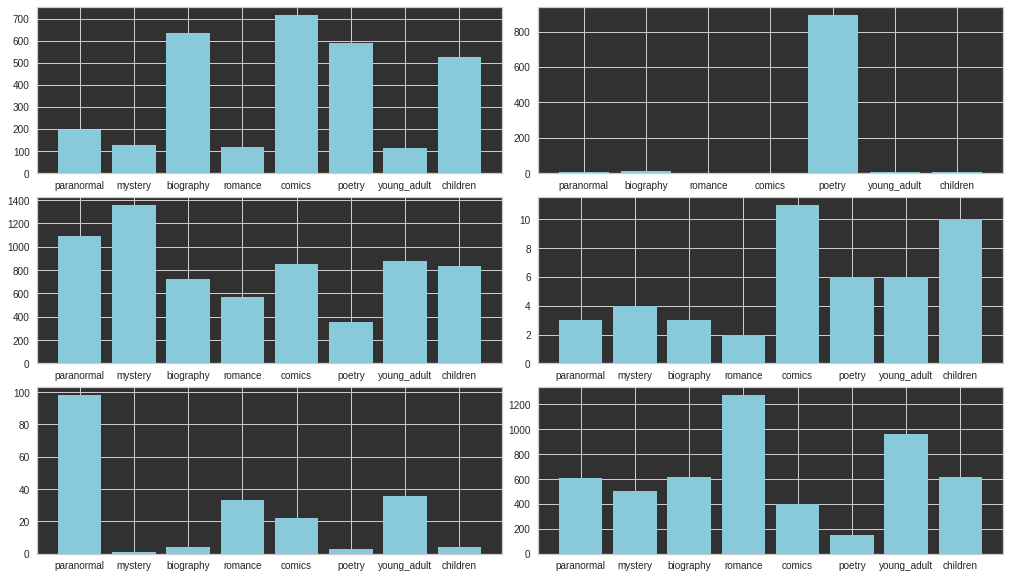

In [ ]:
#@title 
# fazer um histograma com para cada cluster com a quantidade por genero

fig = plt.figure(figsize = (14,8), facecolor = None, frameon=False) 

for i in range(6):
  grupo = df.loc[df['cluster_ward_6_150'] == i]
  resultados = grupo['genre'].value_counts(sort=False)
  names = resultados.index
  resultados = resultados.values

  pos = i + 1

  fig = plt.subplot(3, 2, pos, facecolor='#313131')

  plt.bar(names, resultados, color='c')
  plt.tight_layout(pad = 0.5) 

plt.show()

### Ampliando a dimensão

Foi testado o aumento no número de componentes do SVD para o agrupamento hierarquico utilizando a distância de ward.

### Dendograma

O dendograma do SVD com 500 componentes não ficou muito diferente do dendograma com 150 componentes. Desse modo foi testado o mesmo número de clustes para o svd 500, isto é, 6 clusters.

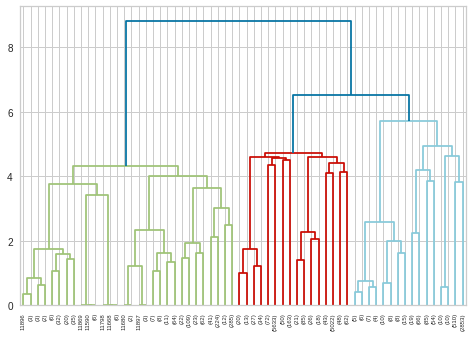

In [ ]:
agrup_hie_ward_500 = hierarchy.linkage(svd_500_out, method='ward')
hierarchy.dendrogram(agrup_hie_ward_500,p=5,truncate_mode="level");

In [ ]:
print("HIERARQUICO WARD 6")
hie_ward_6 = AgglomerativeClustering(6, linkage = 'ward')
clusters_hie_ward_6 = hie_ward_6.fit(svd_150_out);
np.unique(clusters_hie_ward_6.labels_, return_counts=True)

HIERARQUICO WARD 6


(array([0, 1, 2, 3, 4, 5]), array([3032,  934, 6655,   45,  201, 5133]))

Como é possível ver no gráfico abaixo, o aumento do número de componentes não resultou numa melhora no agrupamento das descrições. A distribuição de elementos (quantidade) e de gêneros foi praticamente a mesma. 

In [ ]:
df['cluster_ward_6_500'] = clusters_hie_ward_6.labels_

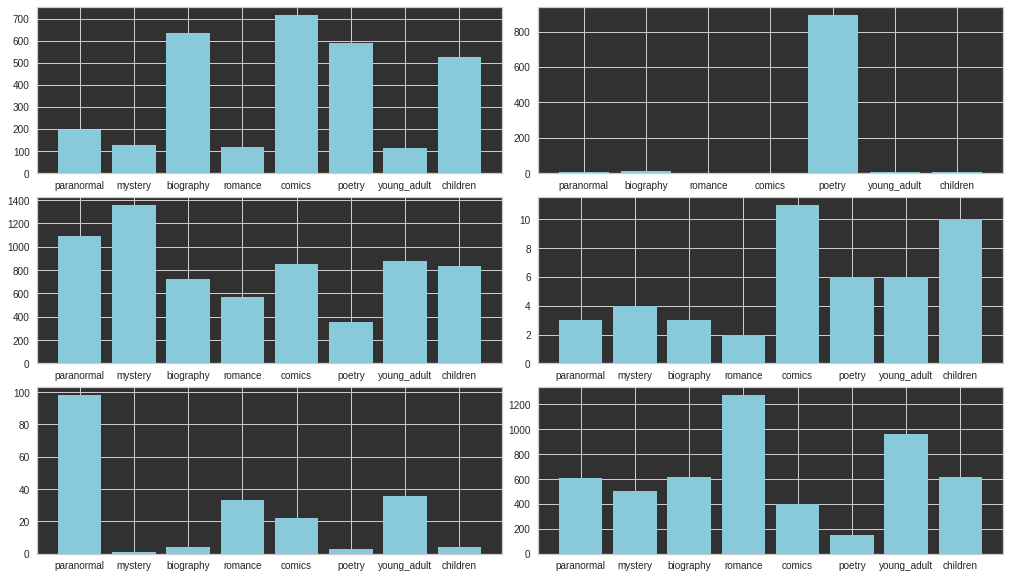

In [ ]:
#@title 
# fazer um histograma com para cada cluster com a quantidade por genero

fig = plt.figure(figsize = (14,8), facecolor = None, frameon=False) 

for i in range(6):
  grupo = df.loc[df['cluster_ward_6_500'] == i]
  resultados = grupo['genre'].value_counts(sort=False)
  names = resultados.index
  resultados = resultados.values

  pos = i + 1

  fig = plt.subplot(3, 2, pos, facecolor='#313131')

  plt.bar(names, resultados, color='c')
  plt.tight_layout(pad = 0.5) 

plt.show()

# Conclusão

Tendo em vistas os testes realizados ao longo desse trabalho, concluiu-se que para cada um dos modelos os melhores resultados obtidos foram ao utilizar os seguintes parâmetros:

- **Kmeans**: svd = 500, k = 5
- **Hierarquico**: svd = 150, k = 6, distancia = ward

Comparando os resultados destes modelos, o que melhor agrupou os dados conforme as descrições dos livros, foi o Kmeans. A medida utilizada para esta conclusão foi a distinção de gêneros em clusters diferentes. 

O Kmeans conseguiu agrupar os gêneros poetry e mystery em dois clusters, contendo cada um mais de 50% dos dados utilizados para estas categorias. Outro detalhe importante, foi que o algoritmo conseguiu realizar uma correlação sintática entre os gêneros romance e young adult, agrupando cerca de 50% de cada um destes gêneros em um único cluster. Concluindo assim que a escolhe do algoritmo impactou significativamento no resultado.

Pela análise realizada, notou-se que há diferença nas distribuições dos gêneros por grupos, uma vez que os gêneros não estavam espalhados uniformemente pelos grupos, e sim concentrados em alguns. Concluiu-se também que existe alguma relação entre as descrições dos livros e seus gêneros, no entanto essa relação não é forte o suficiente para conseguir distinguir todos os gêneros em clusters diferentes.